In [269]:
import os
import re
import sqlalchemy

class Activity():
    
    def __init__(self):
        self.prefix = '/srv'
        self.user  = os.environ.get('JUPYTERHUB_USER') or 'jovyan'
        self.users = list(self._users())
        self.engine = sqlalchemy.create_engine('sqlite:///jovyan.db')
        
    def _users(self):
        pat = re.compile(r"^u\d{6}\w$") # OUID
        if os.path.isdir(self.prefix):
            yield from filter(pat.match, os.listdir(self.prefix))
        else:
            yield from ()

In [270]:
act=Activity()

In [271]:
act.user

'jovyan'

In [2]:
from datetime import datetime as dt

class Activity(Activity):
    
    def _logfile(self, 
                 user=os.environ.get('JUPYTERHUB_USER') or 'jovyan', 
                 date=dt.now().strftime('%Y%m%d')):
        
        if os.path.isdir(self.prefix) and os.access(self.prefix, os.W_OK):
            prefix=self.prefix+('/'+user)
            if not os.path.exists(prefix):
                os.makedirs(prefix)
        else:
            prefix='.'
        return prefix+'/'+date+'.log'
    
    def _logfiles(self, sfx="", user=os.environ.get('JUPYTERHUB_USER') or 'jovyan'):
        
        if os.path.isdir(self.prefix):
            prefix=self.prefix+('/'+user)
        else:
            prefix='.'
        if os.path.isdir(prefix):
            pat = re.compile(r"^(\d{8})"+sfx+r"\.log$")
            for f in os.listdir(prefix):
                r = pat.search(f)
                if r:
                    yield r.group(1)
        yield from ()

In [3]:
act=Activity()

In [4]:
[user for user in act._users()]

[]

In [5]:
act._logfile().replace('.log', '-exc.log')

'./20220529-exc.log'

In [6]:
list(set(act._logfiles(sfx='-nbg')))

['20220527', '20220516', '20220517', '20220524']

* [sql - Passing table name as a function parameter in Python/Pandas/PostgreSQL - Stack Overflow](https://stackoverflow.com/questions/43889687/passing-table-name-as-a-function-parameter-in-python-pandas-postgresql)
* [python - Pandas read_sql with parameters - Stack Overflow](https://stackoverflow.com/questions/24408557/pandas-read-sql-with-parameters)

In [237]:
qry

'select * from {table}'

In [259]:
import pandas as pd
import datetime

class Activity(Activity):
    
    def activity(self, user=os.environ.get('JUPYTERHUB_USER') or 'jovyan'):
  
        qry_tmpl = '''select * from {table}'''
        qry = qry_tmpl.format(**dict(table='nbgrader'))

        try:
            df = pd.read_sql(qry, self.engine, 
                             parse_dates=['index'])
            df.set_index('index', drop=True, inplace=True)
            df.index.name = 'time'
            latest_index = df.index.to_pydatetime()[-1]
        except sqlalchemy.exc.SQLAlchemyError:
            latest_index = dt.min
        print(latest_index)

        pat = re.compile(r'(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2}).*:summary: \((\d+), (\d+), (\d+)\)')

        for d in sorted(list(set(act._logfiles(sfx='-nbg')))):
            try:
                with open(self._logfile(date=d).replace('.log','-nbg.log'), 'r') as f:
                    for l in f:
                        r = pat.search(l)
                        if r:
                            dy, dm, dd, th, tm, ts, c, p, f = (int(s) for s in r.groups())
                            d = datetime.datetime(dy, dm, dd, th, tm, ts)
                            #print(pd.Timestamp(d), c, p, f)
                            if d > latest_index and (int(p)+int(f))> 0:
                                #ts_data = np.array((1.,(3*p+f)/(p+f)))
                                #df_new = pd.DataFrame([ts_data])
                                #df_new.index = [pd.Timestamp(d)]
                                df_new = pd.DataFrame([[1., (3*p+f)/(p+f)]], 
                                                      columns=["y", "pass"],
                                                      index=[pd.Timestamp(d)])
                                df_new.to_sql('nbgrader', self.engine, if_exists='append')
            except:
                pass

In [260]:
act=Activity()

In [261]:
act._logfile(date='20220517').replace('.log', '-nbg.log')

'./20220517-nbg.log'

In [262]:
act.activity()

0001-01-01 00:00:00


In [263]:
from datetime import datetime

In [264]:
datetime(2022,5,24,0,0,0)

datetime.datetime(2022, 5, 24, 0, 0)

In [268]:
qry_tmpl = '''select * from {table} where "index" between :dstart and :dfinish'''
qry = qry_tmpl.format(**dict(table='nbgrader'))

df = pd.read_sql(qry, act.engine, 
                 parse_dates=['index'], 
                 params={'dstart':  datetime(2022,5,24,0,0,0),
                         'dfinish': datetime(2022,5,24,23,59,59)})
df.set_index('index', drop=True, inplace=True)
df.index.name = 'time'
df

,y,pass
time,,
2022-05-24 13:46:20,1.0,3.0
2022-05-24 14:29:54,1.0,3.0
2022-05-24 14:50:09,1.0,3.0
2022-05-24 14:50:18,1.0,3.0
2022-05-24 14:55:00,1.0,3.0


In [251]:
dt.min

datetime.datetime(1, 1, 1, 0, 0)

In [163]:
class Activity(Activity):
    
    def activity2(self, user=os.environ.get('JUPYTERHUB_USER') or 'jovyan'):

        pat = re.compile(r"^#\[Out\]#")
        
        def _register(d, r):
            df = pd.DataFrame([r], 
                              columns = ["user","y","script"], 
                              index=[pd.Timestamp(d)])
            #df.to_sql('nbgrader', self.engine, if_exists='append')
            print(df)

        for d in sorted(list(set(act._logfiles()))):
            try:
                with open(self._logfile(date=d), 'r') as f:
                    lp, dp = "", dt.min
                    for line in f:
                        try:
                            dc = dt.strptime(line, "# %a, %d %b %Y %H:%M:%S ")
                            if lp and dp > dt.min:
                                _register(dp, [user,1.,lp])
                            lp, dp = "", dc
                        except:
                            if not pat.match(line):
                                lp+=line
                    else:
                        _register(dp, [user,1.,lp])
                        #print('EOF')
            except:
                pass

In [164]:
act=Activity()

In [165]:
act.activity2()

                       user    y  script
2022-04-25 14:52:08  jovyan  1.0  path\n
                       user    y                             script
2022-04-25 14:53:43  jovyan  1.0  path.replace('.log','-exc.log')\n
                       user    y                              script
2022-04-25 14:53:55  jovyan  1.0  path.replace('.log$','-exc.log')\n
                       user    y  \
2022-04-25 14:55:28  jovyan  1.0   

                                                                script  
2022-04-25 14:55:28  # [python - cannot override sys.excepthook - S...  
                       user    y                       script
2022-04-25 14:55:32  jovyan  1.0  _showtraceback.__module__\n
                       user    y  \
2022-04-25 14:55:32  jovyan  1.0   

                                                                script  
2022-04-25 14:55:32  IPython.core.interactiveshell.InteractiveShell...  
                       user    y script
2022-04-25 14:55:33  jovyan  1.0  1/0\n
  

In [156]:
df_new = pd.DataFrame([[1, "tako"]])
print(df_new)

   0     1
0  1  tako


In [157]:
if len("tako")>0:
    print("ika")

ika


In [93]:
act._logfile(date='20220425')

'./20220425.log'

In [294]:
len("")

0

In [171]:
inspector = sqlalchemy.inspect(act.engine)
inspector.get_table_names()

['nbgrader']

* [python - How to set a timer & clear a timer? - Stack Overflow](https://stackoverflow.com/questions/24968311/how-to-set-a-timer-clear-a-timer)

In [177]:
import asyncio

async def handler(signum, frame):
    print("helo")


In [180]:
from timeout_decorator import timeout, TimeoutError
import time

In [182]:

@timeout(3)
def l():
    while True:
        print('tick')
        time.sleep(1)

try:
    l()
except TimeoutError:
    pass

tick
tick
tick


In [195]:
from time import sleep
from threading import Timer

def timeout():
    print("Tick")

t = Timer(3.0, timeout)
t.start()

for _ in range(10):
    t.cancel()
    print('tick')
    t = Timer(3.0, timeout)
    t.start()

sleep(5)
print('Tock')

tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
Tick
Tock


In [85]:
df.iloc[:,1].values

array([3., 3., 3., 3., 1., 3., 3., 3., 3.])

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

def plot_ax(ax, user=os.environ.get('JUPYTERHUB_USER') or 'jovyan'):
    df = pd.read_sql('''select * from nbgrader''',
                     act.engine, parse_dates=['index'])
    df.set_index('index', drop=True, inplace=True)
    df.index.name = 'time'
    if len(df)>0:
        cmap = plt.cm.Spectral
        ax.scatter(
            x=df.index, y=df['y'].values, 
            c=df['pass'].values, s=df['pass'].values*500,
            cmap='Spectral',
            alpha=0.4, edgecolor='none'
        )
    ax.set_ylabel(user, rotation=0, ha="right", va="center")

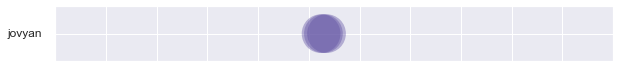

In [90]:
from datetime import date
from datetime import time

fig = plt.figure(figsize=(10,1))
ax = fig.add_subplot(1,1,1)

plt.setp(ax, xlim=(pd.Timestamp(dt.combine(date.today(),time(dt.now().hour-10,))), 
                   pd.Timestamp(dt.combine(date.today(),time(dt.now().hour,59,59)))))
plt.setp(ax, ylim=(0,2))
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plot_ax(ax)